In [56]:
####################################
#ENVIRONMENT SETUP

In [57]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [58]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [59]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [60]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [61]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Domain_Profiles", dataName="Eulerian_Profiles",
                                dtype='float32')

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/Domain_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI

In [62]:
#JOB ARRAY SETUP
UsingJobArray=True

def GetNumJobs(res):
    if res=='1km':
        num_jobs=20
    elif res=='250m': 
        num_jobs=100
    return num_jobs
num_jobs = GetNumJobs(ModelData.res)
SlurmJobArray = SlurmJobArray_Class(total_elements=ModelData.Ntime, num_jobs=num_jobs, UsingJobArray=UsingJobArray)
start_job = SlurmJobArray.start_job; end_job = SlurmJobArray.end_job

def GetNumElements():
    num_elements = np.arange(ModelData.Ntime)[start_job:end_job]
    return num_elements
num_elements = GetNumElements()

Running timesteps from 0:7 



In [63]:
##############################################
#DATA LOADING FUNCTIONS

In [64]:
# #DOMAIN SUBSETTING #*#*
# ############################################################

# #FINDING NEW LEFT T-BOUNDARY
# dt=data1['time'][1].item()/1e9 #seconds per timestep
# dhours=(dt/60**2) #hours per timestep
# start_hour=4 #10:00 am
# t_start=int(start_hour/dhours)
# #FINDING NEW RIGHT T-BOUNDARY
# end_hour=11 #5pm
# t_end=int(end_hour/dhours)
# #PRINTING
# print(f't in {t_start}:{t_end}')


# #FINDING NEW TOP Z-BOUNDARY
# dzh=data1['zh']
# zh_bottom=0; zh_top=np.where(dzh>=19)[0][0]
# dzf=data1['zf']
# zf_bottom=0; zf_top=np.where(dzf>=20)[0][0]
# #PRINTING
# print(f'zh_top at {zh_bottom}:{zh_top}')

# #FINDING THE NEW LEFT X-BOUNDARY
# ocean_percent=2/8
# left_to_coast=data1['xh'][0]+(data1['xh'][-1]-data1['xh'][0])*ocean_percent
# where_coast_xh=np.where(data1['xh']>=left_to_coast)[0][0]#-25
# where_coast_xf=np.where(data1['xf']>=left_to_coast)[0][0]#-25

# #FINDING THE NEW RIGHT X-BOUNDARY
# right_fraction=80/100
# # Normalize to start from zero
# xf = data1['xf'] - data1['xf'][0]
# xh = data1['xh'] - data1['xh'][0]

# # Total physical length
# xf_max = xf[-1]
# xh_max = xh[-1]

# # Find index where physical location exceeds 80% of domain
# end_xf = np.where(xf > right_fraction * xf_max)[0][0]
# end_xh = np.where(xh > right_fraction * xh_max)[0][0]

# # Example: printing region from coast to 80% mark
# print(f'x in {where_coast_xh}:{end_xh} FOR LAND')

# #SUBSETTING CODE
# data1=data1.isel(time=slice(t_start,None),zh=slice(zh_bottom,zh_top),zf=slice(zf_bottom,zf_top),xh=slice(where_coast_xh,end_xh+1),xf=slice(where_coast_xf,end_xf+1))
# A_ds1=A_ds1.isel(time=slice(t_start,None),zh=slice(zh_bottom,zh_top),xh=slice(where_coast_xh,end_xh+1))

In [65]:
def CallVariables(ModelData, DataManager, timeString, varNames):
    varDictionary = {}
    for varName in varNames:
        varDictionary[varName] = CallVariable(ModelData, DataManager, timeString, variableName=varName)
    return varDictionary

def GetBinaryArrays(DataManager, timeString):
    varNames = ['A_g', 'A_c']
    VARs = CallVariables(ModelData, DataManager, timeString, varNames)
    return (VARs[k] for k in varNames)

In [67]:
####################################
#Functions

In [227]:
# Thresholds

class CLASS_DomainProfiles:
    """
    A utility class for constructing and binning vertical domain profiles.
    """
    
    # @staticmethod
    # def GetCloudyUpdraftThresholds(): #not needed since eulerian_binary arrays were calculated previously
    #     w_thresh1=0.1
    #     w_thresh2=0.5
    #     qcqi_thresh=1e-6
    #     return w_thresh1,w_thresh2,qcqi_thresh

    @staticmethod
    def InitializeProfiles(VARs, ModelData):
        zhs = ModelData.zh
        
        # Initialize profiles for each variable
        profiles = {}
        for var in VARs:
            if 'wb' in var: zhs = ModelData.zf #since w budgets are stored on cell edge
            profiles[var] = np.zeros((len(zhs), 3))  # column 1: var, column 2: counter, column 3: list of zhs
            profiles[var][:, 2] = zhs
    
        #####
        VARs_squares = [key + "_squares" for key in VARs.keys()]
        for var_squares in VARs_squares:
            if 'wb' in var_squares: zhs = ModelData.zf #since w budgets are stored on cell edge
            profiles[var_squares] = np.zeros((len(zhs), 3))  # column 1: var, column 2: counter, column 3: list of zhs
            profiles[var_squares][:, 2] = zhs
        #####
    
        return profiles, VARs_squares

    @staticmethod
    def GetUpdraftMask(data_type, A_g, A_c):
        # Threshold mask
        if data_type == "general":
            where_updraft = (A_g==True)
        elif data_type == "cloudy":
            where_updraft = (A_c==True)
        return where_updraft

    @staticmethod
    def GetIndexes(where_updraft):
        # Get Indexes
        z_ind, y_ind, x_ind = np.where(where_updraft)
        return z_ind, y_ind, x_ind

    @staticmethod
    def MakeProfiles(VARs, VARs_squares, profiles, where_updraft, z_ind):
        # Make Profiles
        # Iterate over each variable in var_names and bin the data
        for (var,var_squares) in zip(VARs,VARs_squares):
            masked_data = VARs[var][where_updraft]
            np.add.at(profiles[var][:, 0], z_ind, masked_data)
            np.add.at(profiles[var][:, 1], z_ind, 1)
            np.add.at(profiles[var_squares][:, 0], z_ind, masked_data**2)
            np.add.at(profiles[var_squares][:, 1], z_ind, 1)
    
        return profiles

    @staticmethod
    def DomainProfile(VARs,data_type, A_g,A_c):
    
        # Initialize profiles for each variable
        profiles, VARs_squares = CLASS_DomainProfiles.InitializeProfiles(VARs, ModelData)
    
        # Threshold mask
        where_updraft = CLASS_DomainProfiles.GetUpdraftMask(data_type, A_g, A_c)
    
        # Get Indexes
        z_ind, _, _ = CLASS_DomainProfiles.GetIndexes(where_updraft)
    
        # Make Profiles
        profiles = CLASS_DomainProfiles.MakeProfiles(VARs, VARs_squares, profiles, where_updraft, z_ind)
    
        return profiles

In [228]:
#*#* also need profiles without no mask for "where_updraft" variable
#*#* may also add another code for a eulerian version of "updraft_area"

In [229]:
# def SaveProfile(Dictionary, data_type, job_id): #*#*
#     dir2=dir+'Project_Algorithms/Domain_Profiles/SBATCH/'
#     if data_type == "general":
#         output_file = dir2+f'job_out/{budget_type}_BUDGET_general_eulerian_profiles_{res}_{t_res}_{Np_str}'
#     elif data_type == "cloudy":
#         output_file = dir2+f'job_out/{budget_type}_BUDGET_cloudy_eulerian_profiles_{res}_{t_res}_{Np_str}'
#     output_file+=f'_{job_id}.h5'
    
#     with h5py.File(output_file, 'w') as f:
#         for var in Dictionary:
#             profile_var = Dictionary[var]
#             f.create_dataset(f'profile_{var}', data=profile_var, compression="gzip")

In [230]:
####################################
#RUN SETUP

In [231]:
################################
#DATA SETUP
################################
def GetVarNames(dataName): 
    if dataName=="Variables":
        varNames = ['winterp', 'qv', 'qc', 'qi', 'qcqi', 'RH_vapor', 'theta_v', 'theta_e', 'MSE', 'HMC','VMF_g','VMF_c']
    if dataName == "Entrainment":
        temp=1 #*#*
    elif dataName=="WQVTH_Budgets": #*#* this wont work currently
         varNames = ["wb_hadv", "wb_vadv", "wb_hidiff", "wb_vidiff", 
                     "wb_hturb", "wb_vturb", "wb_pgrad", "wb_buoy"]
         varNames += ["qvb_hadv", "qvb_vadv", "qvb_hidiff", "qvb_vidiff", 
                     "qvb_hturb", "qvb_vturb", "qvb_mp"]
         varNames += ["ptb_hadv", "ptb_vadv", "ptb_hidiff", "ptb_vidiff", 
                     "ptb_hturb", "ptb_vturb", "ptb_mp", "ptb_rad", "ptb_div", "ptb_diss"]
    return varNames

#*#*
# dataNames = ["Variables", "Entrainment", "WQVTH_Budgets"] #*#* can make it so the function call looks like ./file.py dataName, that way multiple versions can be run at once
# for dataName in dataNames

dataName = "Variables"

In [232]:
########################################
#Running #*#* 

In [233]:
for t in [100]:
    timeString = ModelData.timeStrings[t]
    
    #SLICING DATA
    [A_g,A_c] = GetBinaryArrays(DataManager,timeString)
    
    varNames=GetVarNames(type1)
    for data_type in ['general','cloudy']:

        #Getting Variables
        VARs=CallVariables(ModelData, DataManager, timeString, varNames)

        #Making Profiles
        Dictionary=CLASS_DomainProfiles.DomainProfile(VARs,data_type,A_g,A_c)
    #     # SaveProfile(Dictionary,data_type,job_id)
        
    #     # del VARs, Dictionary

/tmp/ipykernel_2911331/2368700405.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(hey[:,0]/hey[:,1],hey[:,2])


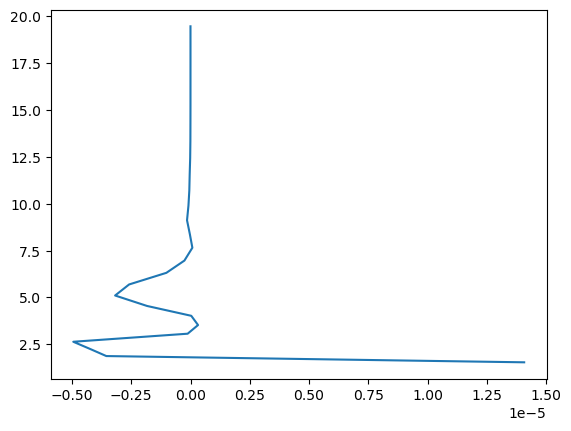

In [237]:
hey=Dictionary["HMC"]
plt.plot(hey[:,0]/hey[:,1],hey[:,2])

In [ ]:
# ######################################### #*#*
# #RECOMBINE SEPERATE JOB_ARRAYsS AFTER
# recombine=False #KEEP FALSE WHEN JOB ARRAY IS RUNNING
# # recombine=True

In [ ]:
# def Recombine(num_jobs,budget_type):
#     dir2=dir+'Project_Algorithms/Domain_Profiles/'
#     print(f"Currently Working on {budget_type} Budgets")
    
#     data_types=['general','cloudy']
#     for data_type in data_types:
#         #MAKING OUTPUT FILE PATH
#         if data_type == "general":
#             output_file = dir2+f'OUTPUT/{budget_type}_BUDGET_general_eulerian_profiles_{res}_{t_res}_{Np_str}.h5'
#         elif data_type == "cloudy":
#             output_file = dir2+f'OUTPUT/{budget_type}_BUDGET_cloudy_eulerian_profiles_{res}_{t_res}_{Np_str}.h5'

#         def GetInputFile(data_type,job_id):
#             if data_type == "general":
#                 input_file = dir2+f'SBATCH/job_out/{budget_type}_BUDGET_general_eulerian_profiles_{res}_{t_res}_{Np_str}_{job_id}.h5'
#             elif data_type == "cloudy":
#                 input_file = dir2+f'SBATCH/job_out/{budget_type}_BUDGET_cloudy_eulerian_profiles_{res}_{t_res}_{Np_str}_{job_id}.h5'
#             return input_file
        
#         #MAKING PROFILES DICTIONARY
#         zhs = data1['zh'].values
#         profiles = {}  #  Store profiles for all variables
#         input_file=GetInputFile(data_type,job_id=1)
#         with h5py.File(input_file, 'r') as f:
#             var_names=list(f.keys())
#         for var in var_names:
#             profiles[var] = np.zeros((len(zhs), 3))  # column 1: var, column 2: counter, column 3: list of zhs
#             profiles[var][:, 2] = zhs 

#         for job_id in np.arange(1,num_jobs+1):
#             if np.mod(job_id,10)==0: print(f"job_id = {job_id}")
#             #CALLING IN DATA
#             input_file=GetInputFile(data_type,job_id)
    
#             #COMPILING PROFILES
#             with h5py.File(input_file, 'r') as f:
#                 for var in var_names:  
#                     profiles[var][:,0:1+1]+=f[f'{var}'][:,0:1+1]
        
#         #SAVING INTO FINAL FORM
#         with h5py.File(output_file, 'w') as f:
#             for var in profiles:
#                 profile_var = profiles[var]
#                 f.create_dataset(f'{var}', data=profile_var, compression="gzip")

In [ ]:
# if recombine==True:
#     # Recombine(num_jobs=num_jobs,budget_type='WQVTH')
#     Recombine(num_jobs=num_jobs,budget_type='W')
#     Recombine(num_jobs=num_jobs,budget_type='QV')
#     Recombine(num_jobs=num_jobs,budget_type='TH')